# Arbitrage repair

In [22]:
import numpy as np
import matplotlib.pyplot as plt 

import gleam as gm
from gleam.dlv import DiscreteLocalVolatilityModel
from gleam.black_scholes import price

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Construct arbitragable call prices 

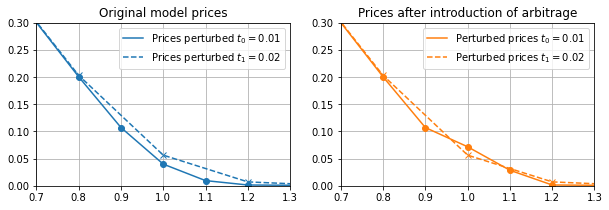

In [178]:
spot = np.array([1])
strikes = np.array(
    [
        [0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5], 
        [0.5, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5], 
    ]
)
tau = np.array([
    [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
])
sigma = np.array([1.0] )

prices = price(spot, strikes, tau, sigma)
prices_perturbed = prices.copy()
prices_perturbed[0, 3] = prices[0, 3] * 1.8
prices_perturbed[0, 4] = prices[0, 4] * 3

fig, axes = plt.subplots(1,2, figsize=(10, 3))

i = 0
axes[i].plot(strikes[0], prices[0], '-', color='C0', label='Prices perturbed $t_0=0.01$') 
axes[i].plot(strikes[0], prices[0], 'o', color='C0')
axes[i].plot(strikes[1], prices[1], '--', color='C0', label='Prices perturbed $t_1=0.02$')
axes[i].plot(strikes[1], prices[1], 'x', color='C0', )
axes[i].grid()
axes[i].set_ylim(bottom=0, top=0.3)
axes[i].set_xlim(0.7, 1.3)
axes[i].legend()
axes[i].set_title('Original model prices')

i = 1
axes[i].plot(strikes[0], prices_perturbed[0], '-', color='C1', label='Perturbed prices $t_0=0.01$') 
axes[i].plot(strikes[1], prices_perturbed[1], '--', color='C1', label='Perturbed prices $t_1=0.02$')
axes[i].plot(strikes[0], prices_perturbed[0], 'o', color='C1',) 
axes[i].plot(strikes[1], prices_perturbed[1], 'x', color='C1',)
axes[i].grid()
axes[i].set_ylim(bottom=0, top=0.3)
axes[i].set_xlim(0.7, 1.3)
axes[i].legend()
axes[i].set_title('Prices after introduction of arbitrage')
plt.show()

## Calibrate DLVs 

In [164]:
dlv = DiscreteLocalVolatilityModel()
dlv.calibrate(
    prices=prices_perturbed,
    strikes=strikes,
    maturities=tau, 
    bounds=np.array([[0.2, 2.0], [0.2, 2.0]]), 
)

## Retrieve prices after arbitrage repair 

In [165]:
prices_arb_free = dlv.get_prices(strikes, tau)

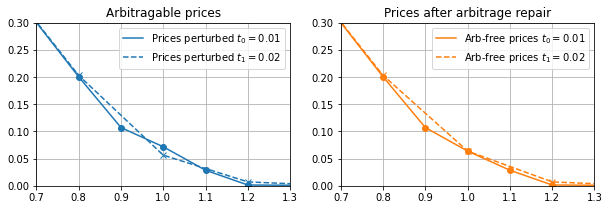

In [180]:
fig, axes = plt.subplots(1,2, figsize=(10, 3))

i = 0
axes[i].plot(strikes[0], prices_perturbed[0], '-', color='C0', label='Prices perturbed $t_0=0.01$') 
axes[i].plot(strikes[1], prices_perturbed[1], '--', color='C0', label='Prices perturbed $t_1=0.02$')
axes[i].plot(strikes[0], prices_perturbed[0], 'o', color='C0') 
axes[i].plot(strikes[1], prices_perturbed[1], 'x', color='C0')
axes[i].grid()
axes[i].set_ylim(bottom=0, top=0.3)
axes[i].set_xlim(0.7, 1.3)
axes[i].legend()
axes[i].set_title('Arbitragable prices')

i = 1
axes[i].plot(strikes[0], prices_arb_free[0], '-', color='C1', label='Arb-free prices $t_0=0.01$') 
axes[i].plot(strikes[1], prices_arb_free[1], '--', color='C1', label='Arb-free prices $t_1=0.02$')
axes[i].plot(strikes[0], prices_arb_free[0], 'o', color='C1') 
axes[i].plot(strikes[1], prices_arb_free[1], 'x', color='C1')
axes[i].grid()
axes[i].set_ylim(bottom=0, top=0.3)
axes[i].set_xlim(0.7, 1.3)
axes[i].legend()
axes[i].set_title('Prices after arbitrage repair')

plt.show()